In [1]:
import numpy as np

train_data = np.load("/kaggle/input/2024-1-1/train.npy", allow_pickle = "TRUE")
test_data = np.load("/kaggle/input/2024-1-1/test.npy", allow_pickle = "TRUE")

In [2]:
train_data_input = train_data.item().get('input')
train_data_label = train_data.item().get('label')

test_data_input = test_data.item().get('input')

In [3]:
print(train_data_label)

[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


In [4]:
train_input = train_data_input.squeeze()
test_input = test_data_input.squeeze()
print(train_input.shape)
print(test_input.shape)

(4608, 22, 1125)
(576, 22, 1125)


### Bandpass Filter

In [5]:
import scipy.signal as signal

# Band-pass filter 설정
lowcut = 0.1
highcut = 30.0
fs = 250.0

def butter_bandpass(lowcut, highcut, fs, order = 5):
    nyquist = 0.5*fs
    low = lowcut/nyquist
    high = highcut/nyquist
    b, a = signal.butter(order, [low, high], btype = 'band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order = 5):
    b, a = butter_bandpass(lowcut, highcut, fs, order = order)
    y = signal.filtfilt(b, a, data, axis = -1)
    return y

In [6]:
train_input_filtered = np.zeros_like(train_input)
for i in range(train_input.shape[0]):
    for j in range(train_input.shape[1]):
        train_input_filtered[i, j, :] = bandpass_filter(train_input[i, j, :], lowcut, highcut, fs)

test_input_filtered = np.zeros_like(test_input)
for i in range(test_input.shape[0]):
    for j in range(test_input.shape[1]):
        test_input_filtered[i, j, :] = bandpass_filter(test_input[i, j, :], lowcut, highcut, fs)

In [7]:
print(f'Train input filtered shape: {train_input_filtered.shape}')
print(f'Test input filtered shape: {test_input_filtered.shape}')

Train input filtered shape: (4608, 22, 1125)
Test input filtered shape: (576, 22, 1125)


### CSP

In [8]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP

In [9]:
# CSP를 적용하기 위해 데이터를 reshape (샘플 수, 채널 수, 시간 포인트 수)
X_train = train_input.astype(np.float64)
# 원-핫 인코딩 레이블을 단일 클래스 레이블로 변환
y_train = np.argmax(train_data_label, axis=1)
X_test = test_input.astype(np.float64)

### LDA

In [10]:
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from mne import create_info
from mne.io import RawArray
from mne.decoding import CSP

# MNE info 객체 생성
sfreq = 250.0  # 샘플링 주파수 (데이터에 따라 조정 필요)
ch_names = [f'EEG {i}' for i in range(22)]  # 채널 이름
ch_types = ['eeg'] * 22  # 모든 채널 타입은 'eeg'
info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# K-Fold Cross-Validation 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-Validation 결과를 저장할 리스트
accuracies = []

# K-Fold Cross-Validation 수행
# K-Fold Cross-Validation 수행
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # RawArray 객체 생성
    raw_train = RawArray(X_train_fold.transpose(1, 0, 2).reshape(22, -1), info)
    raw_val = RawArray(X_val_fold.transpose(1, 0, 2).reshape(22, -1), info)
    
    # CSP 적용
    csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
    X_train_csp = csp.fit_transform(X_train_fold, y_train_fold)
    X_val_csp = csp.transform(X_val_fold)
    
    # LDA 분류기 학습
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_csp, y_train_fold)
    
    # 검증 데이터 예측
    y_val_pred = lda.predict(X_val_csp)
    
    # 검증 데이터 정확도 계산
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    accuracies.append(accuracy)
    print(f'Fold Accuracy: {accuracy}')

Creating RawArray with float64 data, n_channels=22, n_times=4146750
    Range : 0 ... 4146749 =      0.000 ... 16586.996 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=1037250
    Range : 0 ... 1037249 =      0.000 ...  4148.996 secs
Ready.
Computing rank from data with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 22 dim * 4.8e+16  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 22 dim * 4.8e+16  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 22 dim * 5e+16  max singular value)
    Estimated rank (mag): 22


### 결과 출력

In [11]:
# 평균 정확도 출력
mean_accuracy = np.mean(accuracies)
print(f'Mean Accuracy: {mean_accuracy}')

# 최종 모델을 전체 데이터로 학습
raw_train = RawArray(train_input.transpose(1, 0, 2).reshape(22, -1), info)
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
X_train_csp = csp.fit_transform(X_train, y_train)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_csp, y_train)

# 테스트 데이터 예측
raw_test = RawArray(test_input.transpose(1, 0, 2).reshape(22, -1), info)
X_test_csp = csp.transform(X_test)
y_pred = lda.predict(X_test_csp)

# 예측 결과 출력
print(f'Test predictions: {y_pred}')

Mean Accuracy: 0.308591293534096
Creating RawArray with float64 data, n_channels=22, n_times=5184000
    Range : 0 ... 5183999 =      0.000 ... 20735.996 secs
Ready.
Computing rank from data with rank=None
    Using tolerance 2.6e+02 (2.2e-16 eps * 22 dim * 5.4e+16  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6e+02 (2.2e-16 eps * 22 dim * 5.3e+16  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.7e+02 (2.2e-16 eps * 22 dim * 5.5e+16  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22

### t-sne

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE 적용
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_train_csp)

In [18]:
y_train = np.argmax(train_data_label, axis=1)

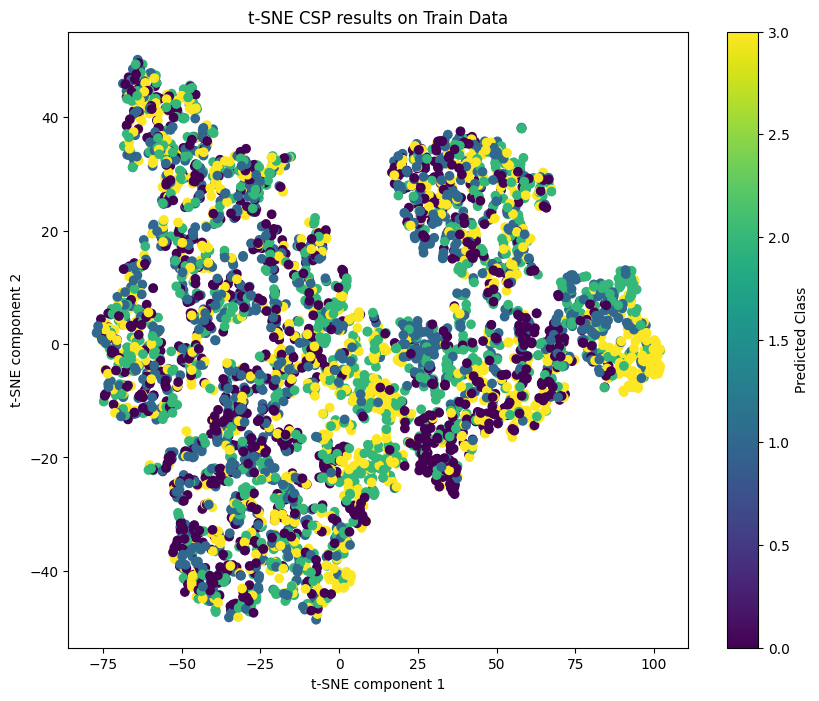

In [25]:

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis')
plt.title('t-SNE CSP results on Train Data')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(label='Predicted Class')
plt.show()

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE 적용
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_test_csp)

In [ ]:
#y_train = np.argmax(train_data_label, axis=1)

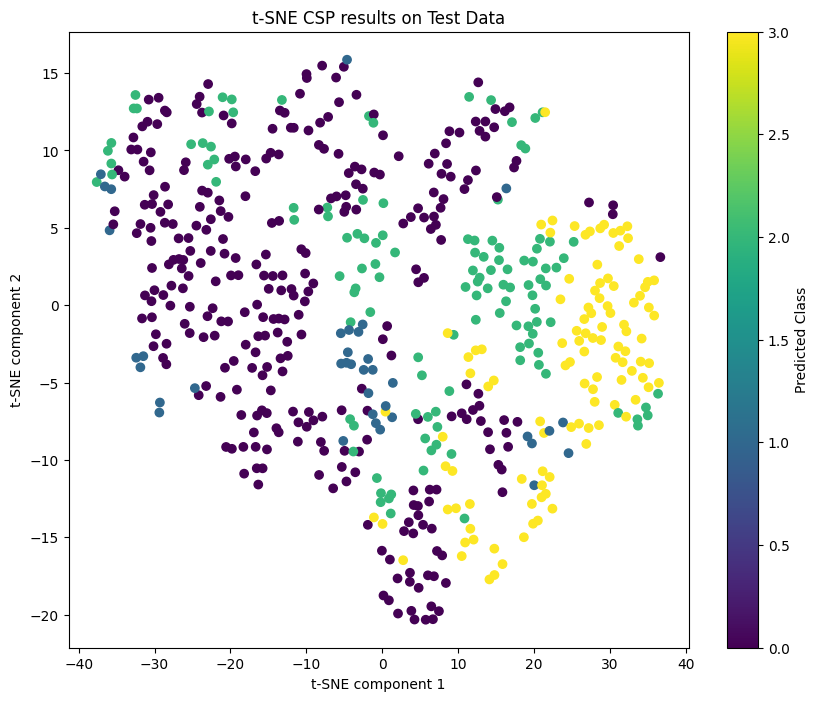

In [28]:

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred, cmap='viridis')
plt.title('t-SNE CSP results on Test Data')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(label='Predicted Class')
plt.show()